Dataset loaded successfully.
Original class distribution:
Class
0    227451
1       394
Name: count, dtype: int64
Resampled class distribution:
Class
0    227451
1    227451
Name: count, dtype: int64
Precision: 0.87
Recall: 0.83


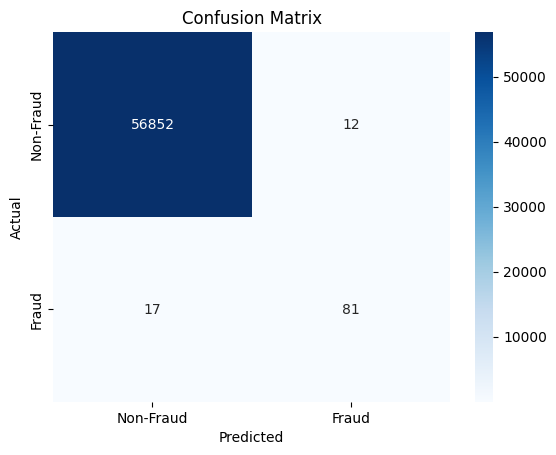

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.87      0.83      0.85        98

    accuracy                           1.00     56962
   macro avg       0.94      0.91      0.92     56962
weighted avg       1.00      1.00      1.00     56962



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE  # Import SMOTE for oversampling

## Kaggle API Setup for Automatic Dataset Download
kaggle_json = {
    "username": "USERNAME",  # Replace with your Kaggle username
    "key": "API_KEY"  # Replace with your Kaggle API key
}

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "w") as f:
    import json
    json.dump(kaggle_json, f)
os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

## Download Dataset from Kaggle
file_path = "creditcard.csv"
if not os.path.exists(file_path):
    try:
        import kaggle
        kaggle.api.dataset_download_files("mlg-ulb/creditcardfraud", path=".", unzip=True)
        print("Dataset downloaded successfully.")
    except Exception as e:
        print(f"Error downloading dataset: {e}")
        raise SystemExit("Dataset not available. Exiting script.")

## Load Dataset
df = None  # Initialize df to avoid NameError
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check if it exists in the directory.")
    raise SystemExit("Dataset not available. Exiting script.")
except Exception as e:
    print(f"Unexpected error: {e}")
    raise SystemExit("Dataset not available. Exiting script.")

## Check for Missing Values
if df.isnull().sum().sum() > 0:
    print("Warning: Dataset contains missing values. Consider handling them appropriately.")

## Data Preprocessing
X = df.drop(columns=['Class'])  # Features
y = df['Class']  # Target

## Standardize Features (SMOTE works better with scaled data)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Split Dataset into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

## Apply SMOTE for Oversampling the Minority Class
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Balances both classes
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original class distribution:\n{y_train.value_counts()}")
print(f"Resampled class distribution:\n{y_train_resampled.value_counts()}")

## Model Training
clf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
clf.fit(X_train_resampled, y_train_resampled)

## Predictions
y_pred = clf.predict(X_test)

## Evaluation
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

## Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))
